In [1]:
%matplotlib inline
import os
import glob
import subprocess
import itertools
from osgeo import gdal
from datetime import datetime
import shutil
import matplotlib.pyplot as plt

In [2]:
cd I:\sentinel2\upper

I:\sentinel2\upper


In [12]:
zips = set([x[16:31] for x in glob.glob(r'zips\*zip')])
l1s = set([x[19:34] for x in glob.glob(r'level1C\*L1C*.SAFE')])
l2s = [x[19:34] for x in glob.glob(r'level2A\*L2A*.SAFE')]
print([l2s.count(x) for x in l2s])
l2s = set(l2s)
not_started = l2s - l1s

logs = glob.glob(r'level2A\*L2A*.SAFE\rep_info\*report.xml')
log_dates = set([x[19:34] for x in logs])
not_finished = l2s - log_dates

contains_error = []
check_for = 'ERROR' #'metadata file is valid'
for log in logs:
    with open(log) as f:
        lines = f.readlines()
    contains = [check_for in l for l in lines]
    if any(contains):
        contains_error.append(log[19:34])
        print(f'{log[19:34]} contains {check_for}!')
        
redo = list(not_started)+list(not_finished)#+contains_error
print(redo)
print(l1s-zips)
# print(len(l1s),len(l2s))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
20160206T221552 contains ERROR!
[]
{'20200311T221559'}


In [32]:
# # for upper
# subset = ['20180705','20210219','20171013']
# still_need =['20200111','20200210','20200331']
# corrupted = ['20190225','20200331','20210130']

subset = redo
safes = glob.glob(r'.\level1C\*SAFE')
print(len(safes))
lines = [f'CALL ..\Sen2Cor-02.09.00-win64\L2A_Process.bat {x}' for x in safes if any([y in x for y in subset])]
lines = ['@ECHO OFF'] + lines
with open('to_level2.bat', 'w') as f:
    for line in lines:
        f.write(line)
        f.write('\n')
# run to_level2.bat on command line

26


In [9]:
b08 = glob.glob('level2A\*\GRANULE\*\IMG_DATA\R10m\*B08_10m.jp2')
lines = [f'CALL rio convert {x} -f ENVI -o envi\\{os.path.basename(x).split(".")[0]}.dat' for x in b08]
lines = ['@ECHO OFF'] + lines
with open('to_envi.bat', 'w') as f:
    for line in lines:
        f.write(line)
        f.write('\n')
# run to_envi.bat on command line

In [4]:
b08dat = glob.glob('*b08_10m.dat')
# b08dat = ['T60HUB_20160206T221552_B08.jp2','T60HUB_20160306T221552_B08.jp2','T60HUB_20160406T221552_B08.jp2']

2016-02-06 22:15:52 26
325 possible combinations


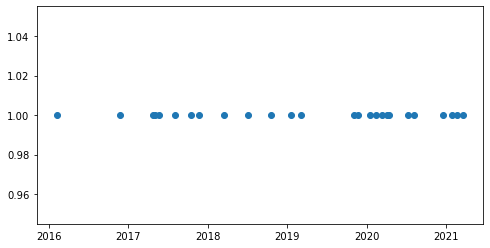

In [20]:
zips = glob.glob('zips\S2*zip')
b08dat = glob.glob('envi\*b08_10m.dat')
dates = [datetime.strptime(os.path.basename(x)[7:22],'%Y%m%dT%H%M%S') for x in b08dat]
vals = [1 for x in dates]
plt.subplots(figsize=(8,4))
plt.scatter(dates, vals)
print(min(dates),len(dates))
print(f'{sum(range(len(dates)))} possible combinations')

In [27]:
dates = [datetime.strptime(os.path.basename(x)[7:22],'%Y%m%dT%H%M%S') for x in b08dat]
file_dic = dict(zip(dates,b08dat))

combos = sorted(sorted(x) for x in itertools.combinations(dates,2))
files = [[file_dic[x[0]],file_dic[x[1]]] for x in combos]

# if using bounds:
#for bounds, sample=x, line=y
#xstart, xend, ystart, yend
poroa1 = '1 10136 10838 9236 10480'
poroa2 = '1 8900 10900 8500 10500'
poroa_lower = '1 9873 10773 9570 10773'
bounds = poroa_lower
dic = {'primary':[f'{os.path.abspath(x[0])} {bounds}' for x in files],
       'secondary':[f'{os.path.abspath(x[1])} {bounds}' for x in files],
       'out_name':[os.path.abspath(os.path.join('poroa',f'cosicorr_{os.path.basename(x[0])[7:22]}_{os.path.basename(x[1])[7:22]}.dat')) for x in files]}

# # if not using bounds:
# dic = {'primary':[f'{os.path.abspath(x[0])}' for x in files],
#        'secondary':[f'{os.path.abspath(x[1])}' for x in files],
#        'out_name':[os.path.join(os.getcwd(),f'cosicorr_{x[0][7:22]}_{x[1][7:22]}.dat') for x in files]}

for key in dic:
    with open(f'{key}.txt', 'w') as f:
        for line in dic[key]:
            f.write(line)
            f.write('\n')

In [24]:
# frequency, winMaxX, winMaxY, winMinX, winMinY, stepX, stepY, nbRobustIteration, MaskThreshold, resampling, grid
options = ['frequency 32 32 32 32 4 4 5 0.9 0 0'] * len(files)
with open('options.txt', 'w') as f:
    for line in options:
        f.write(line)
        f.write('\n')

In [15]:
# create separate vrt files for each band
files = glob.glob('*.dat')
files.sort()
for fname in files:
    for b, dataset in enumerate(['EWOffset','NSOffset','offsetSNR']):
        fname_out = f'{fname.split(".")[0]}_{dataset}.vrt'
        vrt_options = gdal.BuildVRTOptions(bandList=[b+1])
        my_vrt = gdal.BuildVRT(fname_out, fname, options=vrt_options)
        my_vrt = None

In [18]:
# write mintpy file
files = glob.glob('*.vrt')
files.sort()
lines = [f'{f} {f[9:17]} {f[25:33]}\n' for f in files]
with open('metadata.txt', 'w') as f:
    f.writelines(lines)

325 poroa\cosicorr_20160206T221552_20170421T221601.dat


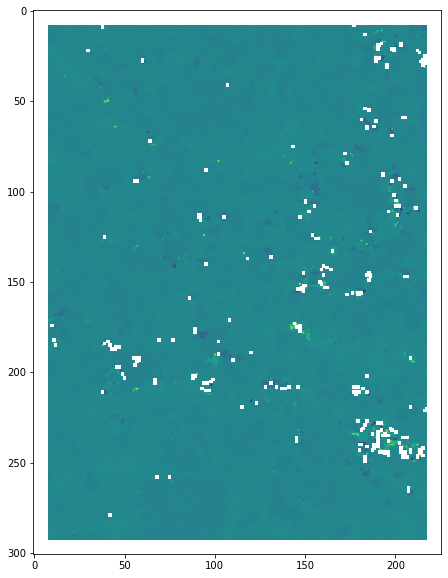

In [36]:
import rasterio

f = glob.glob('poroa\*.dat')
i = 1
print(len(f),f[i])
with rasterio.open(f[i]) as r:
    data = r.read(2)

plt.figure(figsize=(10,10))
plt.imshow(data)